Populating the interactive namespace from numpy and matplotlib
Cu_orbs =  ['dx2y2']
O1_orbs =  ['px']
O2_orbs =  ['py']
Mc= 150
k =  0.0 0.0
VS.dim =  204003
start create_tpd_nn_matrix
start create_tpp_nn_matrix
start create_edep_diag_matrix
dd_state_indices 0 , state:  up dx2y2 dn dx2y2
dp_state_indices 1 , state:  dn dx2y2 0 0 dn py 0 1
dp_state_indices 2 , state:  up dx2y2 0 0 dn py 0 1
dp_state_indices 3 , state:  dn dx2y2 0 0 up py 0 1
dp_state_indices 4 , state:  up dx2y2 0 0 up py 0 1
pp_state_indices 5 , state:  up py 0 1 dn py 0 1
dp_state_indices 1794 , state:  dn dx2y2 0 0 dn px 1 0
dp_state_indices 1795 , state:  up dx2y2 0 0 dn px 1 0
dp_state_indices 1796 , state:  dn dx2y2 0 0 up px 1 0
dp_state_indices 1797 , state:  up dx2y2 0 0 up px 1 0
pp_state_indices 1798 , state:  dn py 0 1 dn px 1 0
pp_state_indices 1799 , state:  up py 0 1 dn px 1 0
pp_state_indices 1800 , state:  dn py 0 1 up px 1 0
pp_state_indices 1801 , state:  up py 0 1 up px 1 0
pp_state_indices 1802 , st

/home/mijiang/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


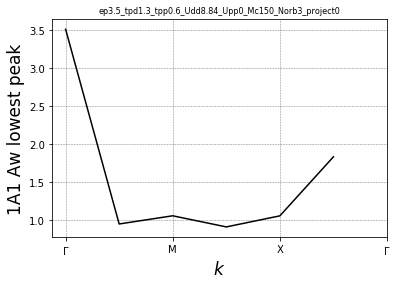

In [1]:
# Adapted from spectral_weight_lanczos.ipynb
# Deleted some useless lines
# This program only concerns 1A1 channel's lowest peak 
# and mainly want to explore its dispersion with k in high symmetry points

%pylab inline

import math
import numpy as np
from scipy.sparse.linalg import inv
#from numpy.linalg import inv
import scipy.sparse as sps
import scipy.sparse.linalg
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')
from pylab import *

import parameters as pam
import lattice as lat
import variational_space as vs
import hamiltonian as ham
import basis_change as basis
import lanczos

M_PI = math.pi
Mc  = pam.Mc
print 'Mc=',Mc

w_vals = pam.w_vals
Norb = pam.Norb
eta = pam.eta
ed  = pam.ed
ep  = pam.ep
project = pam.if_project_out_two_holes_on_different_Cu

if Norb==3 or Norb==7:
    tpd = pam.tpd
    tpp = pam.tpp
elif Norb==9:
    pds = pam.pds
    pdp = pam.pdp
    pps = pam.pps
    ppp = pam.ppp
    
Upp = pam.Upp
if Norb==3:
    Udd = pam.Udd
elif Norb==7 or Norb==9:
    A = pam.A
    B = pam.B
    C = pam.C
                    
Ms = ['-b','-r','-g','-m','-c','-k','-y','--b','--r','--g','--m','--c','--k','--y',\
      '-.b','-.r','-.g','-.m','-.c','-.k','-.y',':b',':r',':g',':m',':c',':k',':y']
##########################################################################
def writefile(fname,kxs,kys, w_max_k, Aw_max_k):
    f = open('./data_1A1_lowest_peak_dispersion/'+fname,'w',1) 
    f.write('kx   ky   w_lowest_peak   Aw_lowest_peak\n')
    
    for i in xrange(0,len(w_max_k)):
        f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'.format(kxs[i],kys[i],w_max_k[i],Aw_max_k[i]))
        
def getAw(matrix,index,VS,w_vals):  
    # set up Lanczos solver
    dim  = VS.dim
    scratch = np.empty(dim, dtype = complex)
    Phi0 = np.zeros(dim, dtype = complex)
    Phi0[index] = 1.0
    solver = lanczos.LanczosSolver(maxiter = pam.Lanczos_maxiter, 
                                   precision = 1e-12, 
                                   cond = 'UPTOMAX', 
                                   eps = 1e-8)
    solver.first_pass(x0 = Phi0, scratch = scratch, H = matrix)
    V, D = solver.lanczos_diag_T()

    # D[0,:] is the eigenvector for lowest eigenvalue
    tab = np.abs(D[0,:])**2

    Aw = np.zeros(len(w_vals))
    for n in range(len(V)):
        Aw += tab[n] * eta / M_PI * ( (w_vals - V[n])**2 + eta**2)**(-1)
    return Aw

def compute_Aw_main(kx,ky):   
    # set up H0
    VS = vs.VariationalSpace(Mc)
    basis.count_VS(VS)
    phase = ham.create_phase_dict(kx,ky,VS)
    T_pd  = ham.create_tpd_nn_matrix(phase,VS)
    T_pp  = ham.create_tpp_nn_matrix(phase,VS)     
    Esite = ham.create_edep_diag_matrix(VS)
    
    # Note tpd and tpp prefactor are considered in hamiltonian.py
    H0 = T_pd + T_pp + ep*Esite

    d_double, p_double = ham.get_double_occu_list(VS)
    
    if Norb==3:
        fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+ \
                '_Udd'+str(Udd)+'_Upp'+str(Upp)+'_kx'+str(kx)+'_ky'+str(ky)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
                '_project'+str(project)
    elif Norb==7:
        fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp) \
              +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
              +'_Upp'+str(Upp)+'_kx'+str(kx)+'_ky'+str(ky)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
                '_project'+str(project)
    elif Norb==9:
        fname = 'ep'+str(ep)+'_pds'+str(pds)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp) \
              +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
              +'_Upp'+str(Upp)+'_kx'+str(kx)+'_ky'+str(ky)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
                '_project'+str(project)
                
    #======================= opt for Norb=3 or 7, 9 ======================================
    # set up H_int
    if Norb==3:
        Hint, Aw_state_indices = ham.create_interaction_matrix_Norb3(VS,d_double,p_double)
        H = H0 + Hint
        H.tocsr()
        
        Aw = np.zeros(len(w_vals))
        Nstate = len(Aw_state_indices)
        for j in range(0,Nstate):
            index = Aw_state_indices[j]
            Aw = getAw(H,index,VS,w_vals)           

            state = VS.get_state(VS.lookup_tbl[index])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=tuple([s1,o1,s2,o2]))

            maxval = max(Aw)
            #xlim([-5,20])
            ylim([0,maxval])
            ylim([0,0.5])
            ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        savefig("Aw_"+fname+".pdf")
        clf()
        
        # find the position of lowest peak and explore its dispersion in high symmetry points of BZ
        maxval = max(Aw)
        print 'max(Aw) = ', maxval
        w_idx = np.argmax(Aw)
        print 'w_max = ', w_vals[w_idx]

        return w_vals[w_idx], maxval

    elif Norb==7 or Norb==9:
        # change the basis for d_double states to be singlet/triplet
        U, S_val, Sz_val = basis.create_singlet_triplet_basis_change_matrix_d_double(phase,VS,d_double)
        U_d = (U.conjugate()).transpose()
        H0_new = U_d.dot(H0.dot(U))
    
        # for multi d-orbital cases, compute A(w) for each symmetry channel
        Aw_dd_total = np.zeros(len(w_vals))
        Aw_d8_total = np.zeros(len(w_vals))
    
        Nsym = len(pam.symmetries)
        for i in range(0,Nsym):
            sym = pam.symmetries[i]
            #print "===================================="
            #print "start computing A_dd(w) for sym", sym
            Hint, dd_state_indices = ham.create_interaction_matrix(VS,sym,d_double,p_double,S_val, Sz_val)
            H = H0_new + Hint
            H.tocsr()
                       
            #dd_states, d8_states, coef_frac_parentage = ham.get_Aw_state(sym)

            # compute G_dd(sym)
            Aw_dd = np.zeros(len(w_vals))
            Aw_d8 = np.zeros(len(w_vals))
        
            for index in dd_state_indices:
                Aw_tmp = getAw(H,index,VS,w_vals)
                Aw_dd += Aw_tmp #*coef_frac_parentage[spinorb]
        
            plt.plot(w_vals, Aw_dd, Ms[i], linewidth=1, label=sym)
            
            # plot atomic multiplet peaks
            maxval = max(Aw_dd)
            yy = [0,maxval]
            xx = [pam.E_1S,pam.E_1S]
            plt.plot(xx, yy,'--k', linewidth=0.5)
            #text(pam.E_1S-0.2, 10.2, 'E_1S', fontsize=5)
            xx = [pam.E_1G,pam.E_1G]
            plt.plot(xx, yy,'--k', linewidth=0.5)
            #text(pam.E_1G-0.2, 10.5, 'E_1G', fontsize=5)
            xx = [pam.E_1D,pam.E_1D]
            plt.plot(xx, yy,'--k', linewidth=0.5)
            #text(pam.E_1D-0.2, 10.8, 'E_1D', fontsize=5)
            xx = [pam.E_3P,pam.E_3P]
            plt.plot(xx, yy,'--k', linewidth=0.5)
            #text(pam.E_3P-0.2, 11.1, 'E_3P', fontsize=5)
            xx = [pam.E_3F,pam.E_3F]
            plt.plot(xx, yy,'--k', linewidth=0.5)
            #text(pam.E_3F-0.2, 11.4, 'E_3F', fontsize=5)
                
            if i==0:
                title(fname, fontsize=8)
            if i==Nsym-1:
                xlabel('$\omega$',fontsize=15)
                
            #xlim([-5,20])
            ylim([0,maxval])
            ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=17)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
            #yticks(fontsize=12)   
        
        savefig("Aw_dd_"+fname+"_sym.pdf")
        clf()
        
        # find the position of lowest peak and explore its dispersion in high symmetry points of BZ
        maxval = max(Aw_dd)
        print 'max(Aw_dd) = ', maxval
        w_idx = np.argmax(Aw_dd)
        print 'w_max = ', w_vals[w_idx]

        return w_vals[w_idx], maxval
         
##########################################################################
if Norb==3:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+ \
            '_Udd'+str(Udd)+'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
            '_project'+str(project)
elif Norb==7:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp) \
          +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
          +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
            '_project'+str(project)
elif Norb==9:
    fname = 'ep'+str(ep)+'_pds'+str(pds)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp) \
          +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
          +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
            '_project'+str(project)
                
cnt = 0
Npts = 2
kxs = []
kys = []
w_max_k = []
Aw_max_k = []
# from (0,0) to (pi,pi)
for kx in np.arange(0.,M_PI,M_PI/Npts):
    ky = kx
    print 'k = ', kx,ky
    w_max, Aw_max = compute_Aw_main(kx,ky)
    kxs.append(kx)
    kys.append(ky)
    w_max_k.append(w_max)
    Aw_max_k.append(Aw_max)
    cnt += 1
    
# from (pi,pi) to (pi,0)
for ky in np.arange(M_PI,0.,-M_PI/Npts):
    kx = M_PI
    print 'k = ', kx,ky
    w_max, Aw_max = compute_Aw_main(kx,ky)
    kxs.append(kx)
    kys.append(ky)
    w_max_k.append(w_max)
    Aw_max_k.append(Aw_max)
    cnt += 1
    
# from (pi,0) to (0,0)
for kx in np.arange(M_PI,0.,-M_PI/Npts):
    ky = 0.0
    print 'k = ', kx,ky
    w_max, Aw_max = compute_Aw_main(kx,ky)
    kxs.append(kx)
    kys.append(ky)
    w_max_k.append(w_max)
    Aw_max_k.append(Aw_max)
    cnt += 1

writefile(fname,kxs,kys,w_max_k, Aw_max_k)
    
plt.plot(arange(0,cnt),w_max_k,'-k')

title(fname, fontsize=8)
xlabel('$k$',fontsize=17)
ylabel('1A1 low peak position w',fontsize=17)
xticks((0,Npts,2.*Npts,3.*Npts), (r'$\Gamma$','M','X',r'$\Gamma$'))
#text(0.45, 0.1, '(a)', fontsize=16)
grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
savefig("1A1_w_lowpeak_dispersion_"+fname+".pdf")

clf()
plt.plot(arange(0,cnt),Aw_max_k,'-k')

title(fname, fontsize=8)
xlabel('$k$',fontsize=17)
ylabel('1A1 Aw lowest peak',fontsize=17)
xticks((0,Npts,2.*Npts,3.*Npts), (r'$\Gamma$','M','X',r'$\Gamma$'))
#text(0.45, 0.1, '(a)', fontsize=16)
grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
savefig("1A1_Aw_lowpeak_dispersion_"+fname+".pdf")